0. Imports and Data

In [20]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import folium

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans

from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial
from statsmodels.discrete.count_model    import ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP

import patsy as patsy
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [3]:
#loading data 
df = pd.read_csv('all_crimes_2022-2025.csv')
df.head()

Crime ID    Month  \
0  6b1be5a8275fcda2982f6de7bb92e03499d33c7fa6316b...  2022-03   
1  6b1be5a8275fcda2982f6de7bb92e03499d33c7fa6316b...  2022-03   
2  b466ed98f60835f379377cda209f72a65f4b594d64b8a6...  2022-03   
3  cc667a5d8c2fa4f30ade960d334d4c1feac01170092470...  2022-03   
4  a60d9d1cff047a67e9a22361a6aa27ad978ec0f71f482a...  2022-03   

                   Reported by                 Falls within  Longitude  \
0  Metropolitan Police Service  Metropolitan Police Service  -0.445898   
1  Metropolitan Police Service  Metropolitan Police Service  -0.445898   
2  Metropolitan Police Service  Metropolitan Police Service  -0.530681   
3  Metropolitan Police Service  Metropolitan Police Service   0.876572   
4  Metropolitan Police Service  Metropolitan Police Service   0.969845   

    Latitude                    Location  LSOA code     LSOA name  \
0  50.803304  On or near Lamorna Gardens  E01031422     Arun 008B   
1  50.803304  On or near Lamorna Gardens  E01031422     Arun 008B   
2  50.804178    On or near South Passage  E01031400     Arun 011A   
3  51.137084    On or near Shopping Area  E01024001  Ashford 009A   
4  51.124173   On or near Petrol Station  E01024013  Ashford 010A   

                     Crime type  \
0  Violence and sexual offences   
1  Violence and sexual offences   
2  Violence and sexual offences   
3         Theft from the person   
4  Violence and sexual offences   

                           Last outcome category  Context  
0                      Status update unavailable      NaN  
1                      Status update unavailable      NaN  
2  Investigation complete; no suspect identified      NaN  
3  Investigation complete; no suspect identified      NaN  
4                      Status update unavailable      NaN

1. EDA (uncomment the needed sniplets)

In [6]:
# ## Data Overview 
# print(f'---Data Overview---')

# print(f'-Rows (instances): {df.shape[0]}\n') 
# print(f'-Columns (attributes): {df.columns}\n')                    
# print(f'-Data types: {df.dtypes}\n')
# print(f'-Null values: {df.isnull().sum()}\n')      # seems that context is always empty 
#                                                    # (number of nulls equals number of overall instances) 


# ## Data Statistics 
# print(f'---Data Statistics---')

# # crime types 
# print(f"-Unique crime types: {df['Crime type'].nunique()}\n")
# print(f"-Amounts per crime type: {df['Crime type'].value_counts()}\n")

# # areas
# print(f"-Unique areas: {df['LSOA name'].nunique()}\n")
# crimes_per_area = df['Falls within'].value_counts()
# print(f"-Crimes per area: {crimes_per_area}\n")   # all fall within the Metropolitan Police Service
# crimes_per_month = df['Month'].value_counts().sort_index()
# print(f"-Crimes per month: {crimes_per_month}\n")

In [5]:
# ## Data Visualization
# print(f'---Data Visualization---')

# # crime types
# plt.figure(figsize=(12,6)) 
# sns.countplot(data=df, y='Crime type', order=df['Crime type'].value_counts().index)
# plt.title('crime types freq')
# plt.show()

# # timetrends
# df['Month'] = pd.to_datetime(df['Month'])
# monthly_crimes = df.groupby(df['Month'].dt.to_period('M')).size()
# monthly_crimes.plot(kind='line', figsize=(14,6))
# plt.title('crimes timetrends')
# plt.ylabel('number of crimes')
# plt.xlabel('month')
# plt.show()

# # outcomes distribution
# plt.figure(figsize=(12,6))
# sns.countplot(data=df, y='Last outcome category', order=df['Last outcome category'].value_counts().index)
# plt.title('outcome distribution')
# plt.show()

# # crimes per area
# top_areas = df['LSOA name'].value_counts().head(10) # grouped by LSOA number, can be changed to
#                                                     # longitude and latitude combination or location 
                                                
# plt.figure(figsize=(12,6))
# sns.barplot(x=top_areas.values, y=top_areas.index)
# plt.title('10 areas with most crimes')
# plt.xlabel('number of crimes')
# plt.ylabel('area')
# plt.show()

# # missing values
# plt.figure(figsize=(10,6))
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
# plt.title('missing values heatmap')
# plt.show()

In [9]:
# ## --- Error ---

# fig = px.scatter_mapbox(df,
#                         lat="Latitude",
#                         lon="Longitude",
#                         color="Crime type",
#                         hover_data=["Location", "Crime type"],
#                         zoom=10,
#                         height=600)

# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()




# df.dropna(subset=['Latitude', 'Longitude'], inplace=True)
# map_center = [df['Latitude'].mean(), df['Longitude'].mean()]

# crime_map = folium.Map(location=map_center, zoom_start=12)
# for idx, row in df.iterrows():
#     folium.CircleMarker(
#         [row['Latitude'], row['Longitude']],
#         radius=2,
#         popup=row['Crime type'],
#         color='blue',
#         fill=True,
#         fill_opacity=0.5
#     ).add_to(crime_map)

# crime_map


2. Burglary and other crimes 

In [14]:
## Restructured data for regression 
print(f'---Restructured data for regression---')

crime_counts = df.groupby(['Month', 'LSOA code', 'Crime type']).size().reset_index(name='Count')

df_grouped = crime_counts.pivot_table(index=['Month', 'LSOA code'], # each crimes is now a column 
                                     columns='Crime type', 
                                     values='Count', 
                                     fill_value=0).reset_index()
df_grouped.head()

---Restructured data for regression---


Crime type      Month  LSOA code  Anti-social behaviour  Bicycle theft  \
0          2022-03-01  E01000001                    0.0            0.0   
1          2022-03-01  E01000002                    0.0            0.0   
2          2022-03-01  E01000003                    0.0            0.0   
3          2022-03-01  E01000005                    2.0            0.0   
4          2022-03-01  E01000006                    0.0            0.0   

Crime type  Burglary  Criminal damage and arson  Drugs  Other crime  \
0                0.0                        0.0    0.0          0.0   
1                0.0                        0.0    0.0          0.0   
2                0.0                        0.0    0.0          0.0   
3                0.0                        0.0    0.0          1.0   
4                1.0                        0.0    1.0          0.0   

Crime type  Other theft  Possession of weapons  Public order  Robbery  \
0                   3.0                    0.0           0.0      0.0   
1                   0.0                    0.0           1.0      0.0   
2                   0.0                    0.0           0.0      0.0   
3                   3.0                    0.0           2.0      0.0   
4                   0.0                    0.0           0.0      3.0   

Crime type  Shoplifting  Theft from the person  Vehicle crime  \
0                   0.0                    1.0            0.0   
1                   0.0                    0.0            0.0   
2                   0.0                    1.0            0.0   
3                   0.0                    3.0            2.0   
4                   0.0                    0.0            2.0   

Crime type  Violence and sexual offences  
0                                    1.0  
1                                    0.0  
2                                    1.0  
3                                    3.0  
4                                    6.0

In [ ]:
# ## Simple Correlation Analysis
# print(f'---Simple Correlation Analysis---')

# corr_matrix = df_grouped.drop(columns=['Month', 'LSOA code']).corr()

# burglary_corr = corr_matrix['Burglary'].sort_values(ascending=False)   # mathematical 
# print(burglary_corr)

# plt.figure(figsize=(8, 8))                                             # visaulization (all cirmes)
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True)
# plt.title('correlationn across all crime types')
# plt.show()

# plt.figure(figsize=(6, 8))                                             # visaulization (with burglary)
# sns.heatmap(corr_matrix[['Burglary']], annot=True, cmap='coolwarm', cbar=True)
# plt.title('correlation with Burglary')
# plt.show()

c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value e

Crime type  Anti-social behaviour  Bicycle theft  Criminal damage and arson  \
E01000001                0.028571      -0.067884                  -0.162650   
E01000002               -0.140084      -0.073746                   0.163461   
E01000003               -0.026288      -0.172414                  -0.142255   
E01000005                0.022329      -0.066519                   0.130025   
E01000006                0.280017            NaN                  -0.152554   

Crime type     Drugs  Other crime  Other theft  Possession of weapons  \
E01000001        NaN          NaN    -0.016720                    NaN   
E01000002  -0.102378          NaN     0.042527                    NaN   
E01000003  -0.103807    -0.072282    -0.199950                    NaN   
E01000005   0.213705    -0.028364     0.038026              -0.159711   
E01000006   0.212879     0.004002     0.054545              -0.071351   

Crime type  Public order   Robbery  Shoplifting  Theft from the person  \
E01000001   

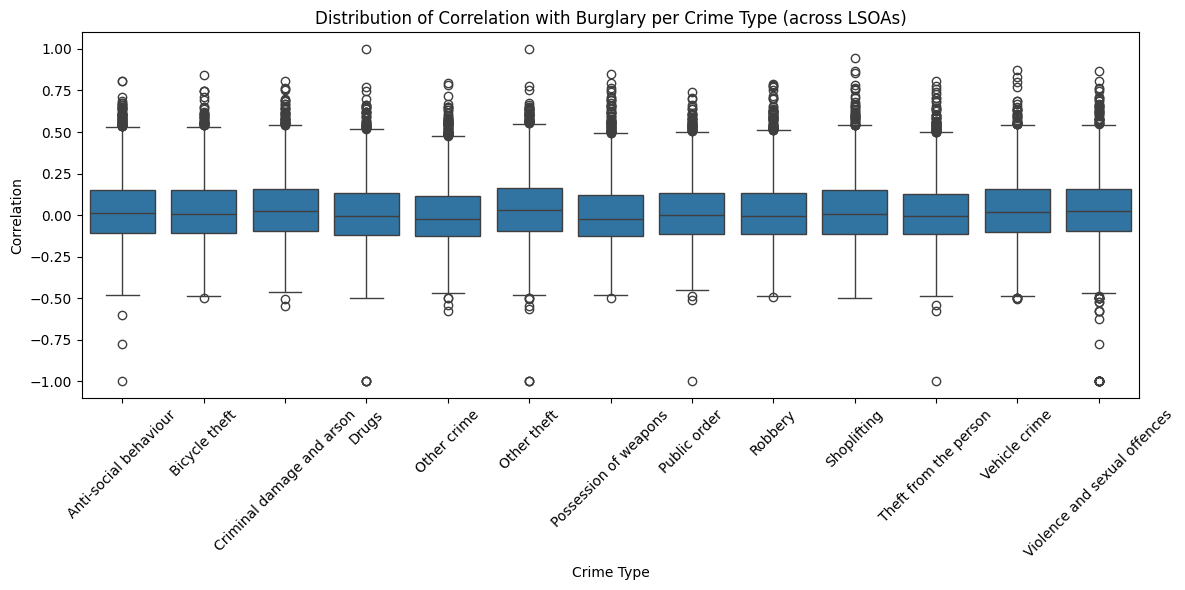

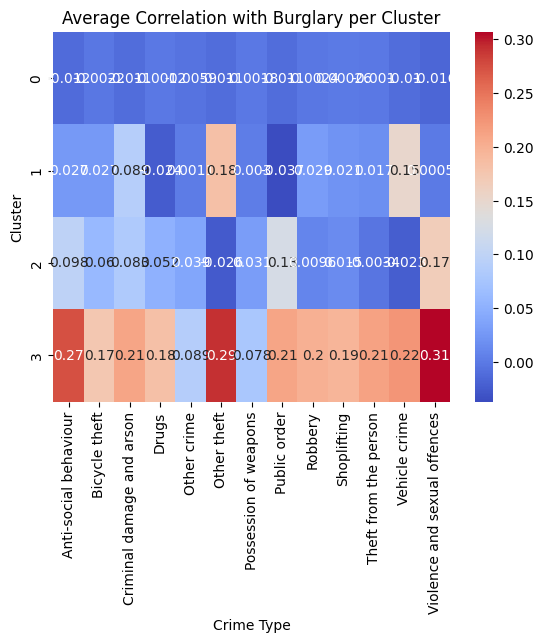

KeyError: 'Burglary'

In [ ]:
## (per LSOA across months) simple correlation analysis

from collections import defaultdict

results = defaultdict(dict)

for lsoa, group in df_grouped.groupby('LSOA code'): # group by LSOA code
    crime_data = group.drop(columns=['Month', 'LSOA code'])
    
    # if crime_data.shape[0] < 2:   # skip where there's not enough data
    #     continue

    corr = crime_data.corrwith(crime_data['Burglary'])
    results[lsoa] = corr.drop(labels='Burglary')  # drop self-correlation

lsoa_corr_df = pd.DataFrame(results).T 
print(lsoa_corr_df.head())


## summary stats
# simple summary stats
summary_stats = lsoa_corr_df.describe()
print("summary stats:")
print(summary_stats)

# ranking crimes by mean correlation with burglary
mean_corr = lsoa_corr_df.mean().sort_values(ascending=False)
print("ranking stats:")
print(mean_corr) # idea: highest mean correlation = most consistently associated with burglary

# vis (violin plots)
long_df = lsoa_corr_df.reset_index().melt(id_vars='index', 
                                          var_name='Crime Type', 
                                          value_name='Correlation')

plt.figure(figsize=(12, 6))
sns.boxplot(data=long_df, x='Crime Type', y='Correlation')
plt.xticks(rotation=45)
plt.title("Distribution of Correlation with Burglary per Crime Type (across LSOAs)")
plt.tight_layout()
plt.show()

# # clustring on correlation 
# lsoa_corr_clean = lsoa_corr_df.fillna(0)  # fill NaN values with 0

# kmeans = KMeans(n_clusters=4, random_state=0) # k-means clustering with 4 clusters
# lsoa_corr_clean['Cluster'] = kmeans.fit_predict(lsoa_corr_clean)

# cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=lsoa_corr_clean.columns[:-1])

# sns.heatmap(cluster_centers, annot=True, cmap='coolwarm')
# plt.title("avg correlation with burglary per cluster")
# plt.xlabel("crime type")
# plt.ylabel("cluster")
# plt.show()

# lsoa_corr_clean['Burglary Correlation'] = lsoa_corr_clean['Burglary']
# cluster_info = pd.DataFrame(columns=['Cluster', 'Crime Type', 'Average Correlation with Burglary'])

# for cluster_num in range(4):  # 4 clusters
#     cluster_data = lsoa_corr_clean[lsoa_corr_clean['Cluster'] == cluster_num]
    
#     for crime_type in cluster_data.columns[:-2]: # ecl burglary
#         avg_corr = cluster_data[crime_type].mean()
        
#         cluster_info = cluster_info.append({
#             'Cluster': cluster_num,
#             'Crime Type': crime_type,
#             'Average Correlation with Burglary': avg_corr
#         }, ignore_index=True)

# print(cluster_info)


<Figure size 1200x600 with 0 Axes>

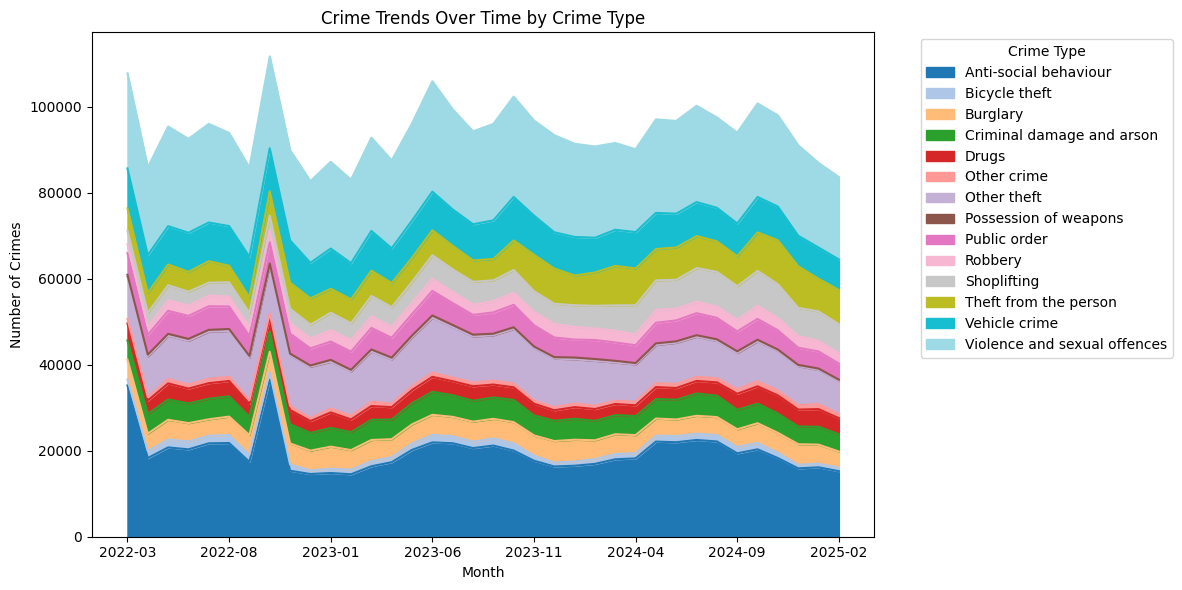

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the raw data with 'Month' and 'Crime type' columns
# Aggregate the data by month and crime type, counting occurrences
df_month_crime = df.groupby(['Month', 'Crime type']).size().unstack(fill_value=0)

# Sort the DataFrame by month (if needed)
df_month_crime = df_month_crime.sort_index()

# Plotting the stacked line chart
plt.figure(figsize=(12, 6))
df_month_crime.plot(kind='area', stacked=True, figsize=(12, 6), cmap='tab20')
plt.title('Crime Trends Over Time by Crime Type')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [82]:
# time series analysis (correlation over time)
monthly_df = df.groupby(['Month', 'Crime type']).size().unstack(fill_value=0)
print(monthly_df.corrwith(monthly_df['Burglary']).sort_values(ascending=False))


Crime type
Burglary                        1.000000
Other theft                     0.540185
Vehicle crime                   0.472006
Robbery                         0.310200
Violence and sexual offences    0.169136
Possession of weapons           0.143877
Criminal damage and arson       0.104987
Theft from the person           0.036275
Drugs                          -0.023915
Public order                   -0.077347
Anti-social behaviour          -0.102606
Other crime                    -0.175368
Bicycle theft                  -0.203293
Shoplifting                    -0.251206
dtype: float64


In [ ]:
mean_burglary = df_grouped['Burglary'].mean()
var_burglary = df_grouped['Burglary'].var()

print(f"mean of burglary: {mean_burglary}")
print(f"var of burglary: {var_burglary}")
if abs(var_burglary - mean_burglary) / mean_burglary > 0.5:
    print("overdispersion — use  NBR (negative binomial regression)")
else:
    print("poisson holds")

# the variance is ~18x the mean -> overdispersion, violating poisson assumption that variance ≈ mean


mean of burglary: 0.8346229411485849
var of burglary: 1.6446913694139698
overdispersion — use  NBR (negative binomial regression)


In [ ]:
# # negative binomial model (ISSUE: size)

# numeric_crime_columns = df_grouped[crime_columns].select_dtypes(include='number').columns
# df_grouped['Total_Crimes'] = df_grouped[numeric_crime_columns].sum(axis=1)

# predictors = df_grouped.columns.difference(['Month', 'LSOA code', 'Burglary', 'Total_Crimes'])

# formula_terms = ' + '.join([f'Q("{col}")' for col in predictors])
# formula = f'Burglary ~ {formula_terms} + Total_Crimes'

# model = smf.glm(formula=formula, data=df_grouped, family=sm.families.NegativeBinomial()).fit()

# print(model.summary())


In [ ]:
# # negative binomial model (ISSUE: NaN)

# X = df_grouped.drop(['Month', 'LSOA code', 'Burglary'], axis=1)
# y = df_grouped['Burglary']

# X = sm.add_constant(X)

# nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# print(nb_model.summary())

# irr = pd.DataFrame({
#     'Crime_Type': X.columns,
#     'IRR': np.exp(nb_model.params),
#     'Lower CI': np.exp(nb_model.conf_int()[0]),
#     'Upper CI': np.exp(nb_model.conf_int()[1]),
#     'p-value': nb_model.pvalues
# })

# print("Incident Rate Ratios:")
# print(irr.sort_values('IRR', ascending=False))


In [ ]:
# (working) negative binomial model 

crime_columns = df_grouped.columns.difference(['Month', 'LSOA code', 'Burglary'])

numeric_crime_columns = df_grouped[crime_columns].select_dtypes(include='number').columns
df_grouped['Total_Crimes'] = df_grouped[numeric_crime_columns].sum(axis=1)

predictors = numeric_crime_columns.difference(['Burglary'])

formula_terms = ' + '.join([f'Q("{col}")' for col in predictors])
formula = f'Burglary ~ {formula_terms} + Total_Crimes'

model = smf.glm(formula=formula, data=df_grouped, family=sm.families.NegativeBinomial()).fit()
print(model.summary())


c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Burglary   No. Observations:               189851
Model:                            GLM   Df Residuals:                   189837
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.2938e+05
Date:                Tue, 06 May 2025   Deviance:                   1.5680e+05
Time:                        12:18:59   Pearson chi2:                 1.59e+05
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1059
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Missing values before cleaning: 0
Burglary Mean: 0.202849019321947, Variance: 3.683267769203257
Overdispersion ratio: 18.157680927002396
Trying standard NegativeBinomial...


c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\genmod\families\varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Error with standard NegativeBinomial: NaN, inf or invalid value detected in weights, estimation infeasible.
Trying NegativeBinomial with alpha=1.0...
Error with alpha initialization: NaN, inf or invalid value detected in weights, estimation infeasible.
Falling back to Poisson regression...
Poisson model fit successfully!

Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Burglary   No. Observations:               795572
Model:                            GLM   Df Residuals:                   795557
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.3203e+05
Date:                Tue, 06 May 2025   Deviance:                   6.1773e+05
Time:                        06:39:07   Pearson chi2:                 2.17e+06
No. Iterations:              

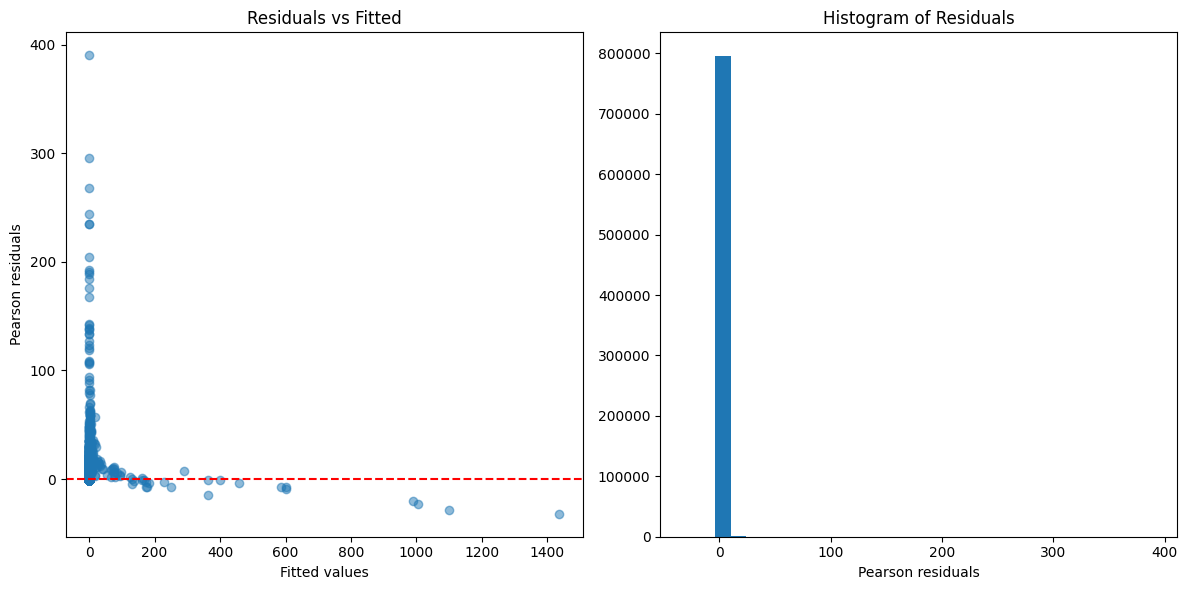

In [ ]:
df_grouped_clean = df_grouped.copy()
print(f"Missing values before cleaning: {df_grouped_clean.isnull().sum().sum()}")
df_grouped_clean = df_grouped_clean.fillna(0)  # fill missing values with zeros

X = df_grouped_clean.drop(['Month', 'LSOA code', 'Burglary'], axis=1)
y = df_grouped_clean['Burglary']

if (y < 0).any(): # cleaning possible negative values
    print("Warning: Negative values found in Burglary counts. Converting to absolute values.")
    y = y.abs()


X = sm.add_constant(X) # const term

print(f"burglary Mean: {y.mean()}, var: {y.var()}") # overdispersion check
print(f"overdispersion ratio: {y.var() / y.mean()}")


try:
    print("Trying standard NegativeBinomial...")
    nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
    print("Model fit successfully!")
except Exception as e1:
    print(f"Error with standard NegativeBinomial: {e1}")
    
    try:
        print("Trying NegativeBinomial with alpha=1.0...")
        nb_family = sm.families.NegativeBinomial(alpha=1.0)
        nb_model = sm.GLM(y, X, family=nb_family).fit()
        print("Model fit successfully!")
    except Exception as e2:
        print(f"Error with alpha initialization: {e2}")
        
        try:
            print("Falling back to Poisson regression...")
            nb_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
            print("Poisson model fit successfully!")
        except Exception as e3:
            print(f"Error with Poisson model: {e3}")
            
            print("Trying robust GLM estimation...")
            nb_model = sm.GLM(y, X, family=sm.families.Poisson()).fit_regularized(alpha=0.01, L1_wt=0)
            print("Robust model fit successfully!")

print("\nmodel summary:")
print(nb_model.summary())

irr = pd.DataFrame({
    'Crime_Type': X.columns,
    'IRR': np.exp(nb_model.params),
    'p-value': nb_model.pvalues
})

try:
    irr['Lower CI'] = np.exp(nb_model.conf_int()[0])
    irr['Upper CI'] = np.exp(nb_model.conf_int()[1])
except:
    print("Confidence intervals not available for this model type")

print("\nIncident Rate Ratios:")
print(irr.sort_values('IRR', ascending=False))

# IRR: for each one-unit increase in a crime type, burglary increases by (IRR-1)*100%
print("\nInterpretation example:")
top_predictor = irr.iloc[1].name  # skip constant
irr_value = irr.loc[top_predictor, 'IRR']
effect = (irr_value - 1) * 100
print(f"For each additional {top_predictor} crime, burglary increases by {effect:.2f}%")

from statsmodels.stats.outliers_influence import variance_inflation_factor ## multicollinearity check

print("\nChecking for multicollinearity (VIF):")
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values('VIF', ascending=False))
print("VIF > 10 indicates problematic multicollinearity")

residuals = nb_model.resid_pearson
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(nb_model.predict(), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Pearson residuals')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Pearson residuals')

plt.tight_layout()
plt.show()

In [ ]:
## zero-inflated negative binomial model

# NaN again 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# check if many zeros in the data
zero_proportion = (df_grouped['Burglary'] == 0).mean()
print(f"Proportion of zeros in burglary data: {zero_proportion:.2%}")

X = df_grouped.drop(['Month', 'LSOA code', 'Burglary'], axis=1)
y = df_grouped['Burglary']

X_array = X.values
y_array = y.values

X_array = sm.add_constant(X_array) # add a constant term

exog_infl = X_array.copy()

zinb_model = sm.ZeroInflatedNegativeBinomialP(
    endog=y_array,
    exog=X_array,
    exog_infl=exog_infl
).fit()

print(zinb_model.summary())

# count model parameters
count_params = pd.DataFrame({
    'Crime_Type': ['const'] + X.columns.tolist(),
    'Coefficient': zinb_model.params[:X_array.shape[1]],
    'p-value': zinb_model.pvalues[:X_array.shape[1]]
})

# inflation model parameters 
infl_params = pd.DataFrame({
    'Crime_Type': ['const'] + X.columns.tolist(),
    'Coefficient': zinb_model.params[X_array.shape[1]:2*X_array.shape[1]],
    'p-value': zinb_model.pvalues[X_array.shape[1]:2*X_array.shape[1]]
})

print("count model parameters:")
print(count_params.sort_values('Coefficient', ascending=False))

print("\nzero-inflation model parameters:")
print(infl_params.sort_values('Coefficient', ascending=False))

# compare model fit with AIC/BIC
try:
    nb_model = sm.GLM(y_array, X_array, family=sm.families.NegativeBinomial()).fit() # regular negative binomial for comparasion
    
    print(f"\nAIC ZINB: {zinb_model.aic}")
    print(f"AIC NB: {nb_model.aic}")
    print(f"BIC ZINB: {zinb_model.bic}")
    print(f"BIC NB: {nb_model.bic}")
    print(f"Lower AIC/BIC indicates better model fit")
except:
    print("Could not compare models")

# zero_proportion is > 30%) -> zero-inflated model

Proportion of zeros in burglary data: 53.53%


c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:4329: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:3936: RuntimeWarning: invalid value encountered in subtract
  llf = (gammaln(y + a1) - gammaln(y + 1) - gammaln(a1) +
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\discrete\discr

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\discrete\count_model.py:324: RuntimeWarning: invalid value encountered in multiply
  hess_arr[i, j + self.k_inflate] = -(score_main[zero_idx, j] *
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\20222358\OneDrive - TU Eindhov

                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:               189851
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                   189836
Method:                                      MLE   Df Model:                           14
Date:                           Tue, 06 May 2025   Pseudo R-squ.:                     nan
Time:                                   12:12:44   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                   -2.3999e+05
Covariance Type:                       nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const   -26.8186        nan        nan        nan         nan         nan
inflate_x1     -158.7329        na

c:\Users\20222358\OneDrive - TU Eindhoven\Desktop\DC-2\Addressing-real-world-crime-and-security-problems-with-data-science\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


3. Regressions revisited 

In [ ]:
y = df['Burglary']      # dependent                    

X = df.drop(columns=['Burglary', 'Month', 'LSOA name'])   # independent 

lsoa  = df['LSOA name']
month = df['Month']

Zero share = 53.7%
Mean=0.83  Var=1.64  Dispersion Index=1.97


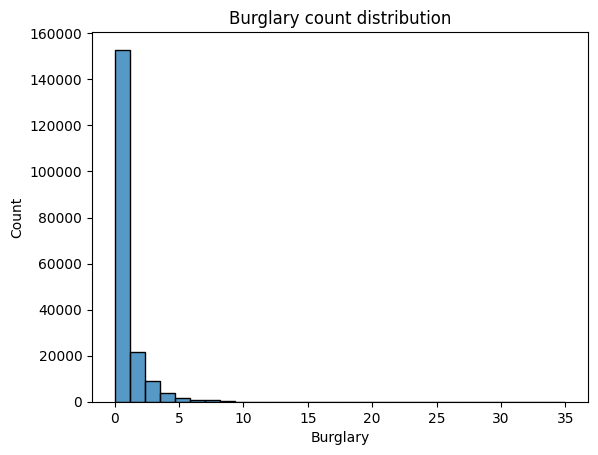

In [ ]:
sns.histplot(y, bins=30); plt.title("Burglary count distribution")

print(f"Zero share = {(y==0).mean():.1%}")

mean_b, var_b = y.mean(), y.var() # check for overdisperion (var to mean)
print(f"Mean={mean_b:.2f}  Var={var_b:.2f}  Dispersion Index={var_b/mean_b:.2f}")


In [ ]:
# # MEMORY INEFFICIENT DENSE MATRIX (ERROR) - ran for 107 minutes with no effect


# # baseline formula (LSOA fixed)
# crime_terms   = " + ".join([f"Q('{c}')" for c in X.columns])
# formula_fixed = f"Burglary ~ {crime_terms} + C(Q('LSOA name'))"   

# #---poisson 
# pois = smf.glm(formula=formula_fixed, data=df,
#                family=sm.families.Poisson()).fit() 
# #---negative binomial
# nb = smf.glm(formula=formula_fixed, data=df,       
#              family=sm.families.NegativeBinomial()).fit()
# #---zero inflated poisson
# zipm = ZeroInflatedPoisson.from_formula(formula_fixed, df, 
#                                         inflation='logit').fit(method='bfgs')
# #---zero inflated nagative binomial 
# zinb = ZeroInflatedNegativeBinomialP.from_formula(formula_fixed, df, 
#                                                   inflation='logit').fit(method='bfgs')

In [ ]:
# # SPARSE MATRIX
# # in the previous trial memory was an issue, so now i'm trying a sparse matrix that skips 0s


# # 1. baseline (dense ndarray)
# crime_cols = [c for c in df.columns if c not in
#               ["Burglary", "Month", "LSOA name"]]
# X_crime = df[crime_cols].to_numpy(dtype=float)      

# # 2. sparse matrix (LSOA as dummy) 
# dummies = pd.get_dummies(df["LSOA name"],
#                          sparse=True,   # !!!
#                          dtype=np.int8) 

# X_lsoa_sparse = dummies.sparse.to_coo()

In [ ]:
# # 3. combining the blocks and adding intercept
# X_crime_sparse = sp.csr_matrix(X_crime)               # dense to sparse
# intercept      = sp.csr_matrix(np.ones((len(df), 1))) # adding a column of 1s

# X_sparse = sp.hstack([intercept, X_crime_sparse, X_lsoa_sparse],
#                      format="csr")                    # final matrix here 
# y = df["Burglary"].to_numpy()

# # estimating memory
# print("sparse shape:", X_sparse.shape)
# print("memory estimation (MB)   :", (X_sparse.data.nbytes +
#                                 X_sparse.indices.nbytes +
#                                 X_sparse.indptr.nbytes) / 1e6)

sparse shape: (190787, 11112)
memory estimation (MB)   : 17.346


In [ ]:
# poiss_dm = Poisson(y, X_sparse).fit(method="lbfgs") # argument error  SPARSE MATRIX DOES NOT WORK WITH GLM
# print("Poisson (discrete) AIC:", poiss_dm.aic)

ValueError: unrecognized data structures: <class 'numpy.ndarray'> / <class 'scipy.sparse._csr.csr_matrix'>

In [ ]:
# # ERROR (passing sparse matrix to glm) 



# grouped = (df
#            .groupby(["Month", "LSOA name", "Crime type"])
#            .size()
#            .unstack(fill_value=0))
# df = grouped.reset_index()         


# # 1. sparse matrix (LSOA as dummy)
# crime_cols = [c for c in df.columns if c not in ["Burglary", "Month", "LSOA name"]]
# X_crime = sp.csr_matrix(df[crime_cols].to_numpy(float))       # dense to sparse

# dummies = pd.get_dummies(df["LSOA name"], sparse=True, dtype=np.int8)
# X_lsoa  = dummies.sparse.to_coo()

# intercept = sp.csr_matrix(np.ones((len(df), 1)))
# X = sp.hstack([intercept, X_crime, X_lsoa], format="csr")    
# y = df["Burglary"].to_numpy()

# print("Design-matrix shape:", X.shape,
#       " | memory ~", (X.data.nbytes + X.indices.nbytes + X.indptr.nbytes) / 1e6, "MB")


# models = {
#     "Poisson" : Poisson(y, X).fit(method="lbfgs"),
#     "NegBin"  : NegativeBinomial(y, X).fit(method="lbfgs"),
#     "ZIP"     : ZeroInflatedPoisson(y, X, exog_infl=np.ones((len(y),1)),
#                                     inflation="logit").fit(method="bfgs"),
#     "ZINB"    : ZeroInflatedNegativeBinomialP(y, X, exog_infl=np.ones((len(y),1)),
#                                               inflation="logit").fit(method="bfgs")
# }

# def pearson_chi2_over_df(res):
#     if hasattr(res, "pearson_chi2"):
#         return res.pearson_chi2 / res.df_resid
#     mu = res.predict()
#     resid = (y - mu) / np.sqrt(mu + 1e-9)
#     return np.sum(resid**2) / (len(y) - res.df_model)

# # 3. fit 
# cmp = pd.DataFrame({
#     "Model"          : models.keys(),
#     "AIC"            : [m.aic for m in models.values()],
#     "BIC"            : [m.bic for m in models.values()],
#     "Pearson χ²/df"  : [pearson_chi2_over_df(m) for m in models.values()]
# }).sort_values("AIC")
# print("\n=== Fit comparison ===")
# print(cmp.to_string(index=False))

# best_name = cmp.iloc[0]["Model"]
# best_res  = models[best_name]
# print(f"\n*** Best model by AIC ⇒ {best_name} ***\n")

# # 4. validate
# cutoff = df["Month"].max() - pd.DateOffset(months=6)
# train_idx = df["Month"] <= cutoff
# test_idx  = ~train_idx

# X_train, y_train = X[train_idx], y[train_idx]
# X_test , y_test  = X[test_idx] , y[test_idx]

# # best
# if best_name == "Poisson":
#     best_train = Poisson(y_train, X_train).fit(method="lbfgs", disp=0)
# elif best_name == "NegBin":
#     best_train = NegativeBinomial(y_train, X_train).fit(method="lbfgs", disp=0)
# elif best_name == "ZIP":
#     best_train = ZeroInflatedPoisson(y_train, X_train,
#                                      exog_infl=np.ones((len(y_train),1)),
#                                      inflation="logit").fit(method="bfgs", disp=0)
# else:
#     best_train = ZeroInflatedNegativeBinomialP(y_train, X_train,
#                                                exog_infl=np.ones((len(y_train),1)),
#                                                inflation="logit").fit(method="bfgs", disp=0)

# pred_test = best_train.predict(X_test)
# rmse = np.sqrt(np.mean((y_test - pred_test)**2))
# print(f"Hold-out RMSE (last 6 months): {rmse:.3f}")

# # resi
# import matplotlib.pyplot as plt, seaborn as sns
# fitted = best_res.predict()
# resid  = (y - fitted) / np.sqrt(fitted + 1e-9)

# sns.scatterplot(x=fitted, y=resid, s=10, alpha=.3)
# plt.axhline(0, ls="--", c="k")
# plt.xlabel("Fitted values"); plt.ylabel("Pearson residuals")
# plt.title(f"Residuals vs Fitted – {best_name}")
# plt.show()

# # coefficient 
# import numpy as np
# if best_name in ["Poisson", "NegBin"]:
#     coef_series = pd.Series(best_res.params, index=["Intercept"]+crime_cols+dummies.columns.tolist())
# else:  # zero-inflated models: params for count part are first len(X[0]) entries
#     k = X.shape[1]
#     coef_series = pd.Series(best_res.params[:k],
#                             index=["Intercept"]+crime_cols+dummies.columns.tolist())

# irr = np.exp(coef_series[:len(crime_cols)+1])   # intercept + crime predictors
# print("\nTop 10 Incidence-Rate Ratios (|IRR − 1| largest):")
# print((irr-1).abs().sort_values(ascending=False).head(10).apply(lambda v: f"{v+1:.3f}"))


new attempt 

In [23]:
df_grouped.head()

Crime type      Month  LSOA code  Anti-social behaviour  Bicycle theft  \
0          2022-03-01  E01000001                    0.0            0.0   
1          2022-03-01  E01000002                    0.0            0.0   
2          2022-03-01  E01000003                    0.0            0.0   
3          2022-03-01  E01000005                    2.0            0.0   
4          2022-03-01  E01000006                    0.0            0.0   

Crime type  Burglary  Criminal damage and arson  Drugs  Other crime  \
0                0.0                        0.0    0.0          0.0   
1                0.0                        0.0    0.0          0.0   
2                0.0                        0.0    0.0          0.0   
3                0.0                        0.0    0.0          1.0   
4                1.0                        0.0    1.0          0.0   

Crime type  Other theft  Possession of weapons  Public order  Robbery  \
0                   3.0                    0.0           0.0      0.0   
1                   0.0                    0.0           1.0      0.0   
2                   0.0                    0.0           0.0      0.0   
3                   3.0                    0.0           2.0      0.0   
4                   0.0                    0.0           0.0      3.0   

Crime type  Shoplifting  Theft from the person  Vehicle crime  \
0                   0.0                    1.0            0.0   
1                   0.0                    0.0            0.0   
2                   0.0                    1.0            0.0   
3                   0.0                    3.0            2.0   
4                   0.0                    0.0            2.0   

Crime type  Violence and sexual offences  
0                                    1.0  
1                                    0.0  
2                                    1.0  
3                                    3.0  
4                                    6.0

In [47]:
import pandas as pd, numpy as np, scipy.sparse as sp
from sklearn.linear_model import PoissonRegressor, TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
from sklearn.preprocessing import StandardScaler

In [ ]:
df = df_grouped.copy()                     

y = df["Burglary"].to_numpy()                                  # dependent variable
crimes = [c for c in df.columns
              if c not in ["Burglary", "Month", "LSOA code"]]  # independent variables
X_dense = df[crimes].to_numpy(dtype=float)

In [49]:
X_sparse = sp.csr_matrix(X_dense)
scaler = StandardScaler(with_mean=False)     # with_mean=False keeps sparsity
X_sparse_std = scaler.fit_transform(X_sparse)


In [50]:
X_tr, X_te, y_tr, y_te = train_test_split(
        X_sparse_std, y, test_size=0.2, random_state=42)

In [51]:
pois = PoissonRegressor(alpha=0, max_iter=1000)
pois.fit(X_tr, y_tr)

y_pred_pois = pois.predict(X_te)
dev_pois = mean_poisson_deviance(y_te, y_pred_pois)

In [52]:
zinb = TweedieRegressor(power=1.5, alpha=0, link="log", max_iter=1000)
zinb.fit(X_tr, y_tr)

y_pred_zinb = zinb.predict(X_te)
dev_zinb = mean_poisson_deviance(y_te, y_pred_zinb)

In [55]:
def irr(model): # incidence-rate ratio
    true_coef = model.coef_ / scaler.scale_          # unstandarize
    return pd.Series(np.exp(true_coef), index=crime_cols)

print(f"poisson       : {dev_pois:.4f}") # mean poisson deviance
print(f"tweedie, which is roughly NB  : {dev_zinb:.4f}")

best = pois if dev_pois <= dev_zinb else zinb
print(f"\nbest model on deviance: {'poisson' if best is pois else 'Tteedie~NB'}")

print("\nincidence-rate ratios (IRR)")
irr(best).sort_values(ascending=False).to_frame("IRR").head(10)

poisson       : 1.4281
tweedie, which is roughly NB  : 1.5223

best model on deviance: poisson

incidence-rate ratios (IRR)


IRR
Bicycle theft                 1.068220
Criminal damage and arson     1.061124
Vehicle crime                 1.032300
Robbery                       1.026404
Anti-social behaviour         1.024560
Violence and sexual offences  1.018028
Public order                  1.009605
Shoplifting                   1.001612
Theft from the person         0.996871
Other theft                   0.995926

In [ ]:
# next step: check for statistical significance (p-values) 